In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

from pandas_datareader import data
from scipy.optimize import minimize

In [2]:
data_collection = pd.read_csv('Final_stock_data_V2.csv')
adjClose_5y = pd.read_csv('Cleaned_AdjCloseP_5y.csv', index_col='Date')
close_5y = pd.read_csv('Cleaned_CloseP_5y.csv', index_col='Date')


In [3]:
tickers = adjClose_5y.columns

In [4]:
adjClose_5y.head()

,AAP,ABT,ACN,ADM,ADP,ADSK,AEE,AEP,AFL,AJG,...,WRLD,WTFC,WTRH,WW,WWD,XOMA,XRX,ZD,ZUMZ,ESNT
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-03,157.890411,39.270012,105.562996,37.597412,87.912636,84.410004,45.868515,53.538227,30.290247,48.557995,...,49.310001,68.225578,9.901,12.29,68.323280,4.45,23.375423,73.565216,21.150000,34.572044
2017-02-06,155.484421,38.948734,105.277184,37.623055,87.549629,82.820000,45.833706,53.362640,30.431515,48.566975,...,49.139999,67.483673,9.900,12.35,68.012421,4.30,23.113874,73.400002,20.450001,34.389118
2017-02-07,154.426956,39.370998,106.881500,38.110218,87.386269,84.500000,45.859814,53.454613,30.449175,48.486065,...,49.840000,67.370773,9.900,12.31,67.740410,4.21,23.113874,73.886955,20.100000,34.697193
2017-02-08,157.870956,38.921196,106.429733,37.144428,87.649460,82.930000,46.242840,53.842827,30.744982,48.602943,...,50.430000,66.956764,9.900,12.28,67.419815,4.15,24.061970,73.034782,19.950001,34.937889
2017-02-09,159.908234,39.049706,107.858849,37.212811,88.620506,83.879997,46.051334,53.522125,30.859760,49.187328,...,51.259998,68.142334,10.000,12.35,68.381561,4.10,23.735037,74.417389,20.650000,34.889748


In [5]:
adjClose_5y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1274 entries, 2017-02-03 to 2022-02-24
Columns: 879 entries, AAP to ESNT
dtypes: float64(879)
memory usage: 8.6+ MB


# ____________________________________________

In [6]:
risk_free_ann_ret_rate = 0.0195

In [7]:
returns_ts = adjClose_5y.pct_change().dropna()
returns_ts

,AAP,ABT,ACN,ADM,ADP,ADSK,AEE,AEP,AFL,AJG,...,WRLD,WTFC,WTRH,WW,WWD,XOMA,XRX,ZD,ZUMZ,ESNT
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-06,-0.015238,-0.008181,-0.002708,0.000682,-0.004129,-0.018837,-0.000759,-0.003280,0.004664,0.000185,...,-0.003448,-0.010874,-0.000101,0.004882,-0.004550,-0.033708,-0.011189,-0.002246,-0.033097,-0.005291
2017-02-07,-0.006801,0.010842,0.015239,0.012949,-0.001866,0.020285,0.000570,0.001724,0.000580,-0.001666,...,0.014245,-0.001673,0.000000,-0.003239,-0.003999,-0.020930,0.000000,0.006634,-0.017115,0.008959
2017-02-08,0.022302,-0.011425,-0.004227,-0.025342,0.003012,-0.018580,0.008352,0.007262,0.009715,0.002411,...,0.011838,-0.006145,0.000000,-0.002437,-0.004733,-0.014252,0.041018,-0.011533,-0.007463,0.006937
2017-02-09,0.012905,0.003302,0.013428,0.001841,0.011079,0.011455,-0.004141,-0.005956,0.003733,0.012024,...,0.016458,0.017706,0.010101,0.005700,0.014265,-0.012048,-0.013587,0.018931,0.035088,-0.001378
2017-02-10,-0.004732,0.004702,0.005300,0.006660,0.001741,-0.007749,0.000567,0.008357,0.001144,0.008408,...,-0.006438,0.004971,0.005000,0.031579,-0.002131,-0.017073,0.005510,0.011451,0.014528,0.007174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-17,-0.008903,-0.025065,-0.032392,-0.003251,-0.018508,-0.044280,0.000474,0.000937,-0.020459,-0.017348,...,-0.058808,-0.043299,-0.043222,-0.009919,-0.006035,-0.012808,-0.047886,-0.006868,-0.045108,-0.040497
2022-02-18,-0.007305,-0.031431,-0.005358,-0.003392,-0.000050,-0.029321,0.001893,0.002573,-0.000475,0.005081,...,-0.000899,-0.008430,-0.071869,-0.027322,0.000915,0.004491,-0.011328,-0.003364,0.003651,0.005136
2022-02-22,-0.055027,0.006165,-0.000218,0.004189,-0.002744,-0.005488,0.002953,0.003267,-0.006332,-0.003565,...,0.001990,-0.000607,-0.090708,-0.046816,-0.026674,0.004471,-0.041247,-0.048383,-0.043656,-0.012664


In [8]:
avg_daily_ret = returns_ts.mean()
avg_daily_ret

AAP     0.000437
ABT     0.000993
ACN     0.000991
ADM     0.000677
ADP     0.000792
          ...   
XOMA    0.002192
XRX     0.000191
ZD      0.000402
ZUMZ    0.001102
ESNT    0.000657
Length: 879, dtype: float64

In [9]:
excess_ret = pd.DataFrame()
excess_ret

""


In [10]:

returns_ts['RiskFree_Rate'] = risk_free_ann_ret_rate/252
avg_rf_ret = returns_ts['RiskFree_Rate'].mean()
returns_ts

,AAP,ABT,ACN,ADM,ADP,ADSK,AEE,AEP,AFL,AJG,...,WTFC,WTRH,WW,WWD,XOMA,XRX,ZD,ZUMZ,ESNT,RiskFree_Rate
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-06,-0.015238,-0.008181,-0.002708,0.000682,-0.004129,-0.018837,-0.000759,-0.003280,0.004664,0.000185,...,-0.010874,-0.000101,0.004882,-0.004550,-0.033708,-0.011189,-0.002246,-0.033097,-0.005291,0.000077
2017-02-07,-0.006801,0.010842,0.015239,0.012949,-0.001866,0.020285,0.000570,0.001724,0.000580,-0.001666,...,-0.001673,0.000000,-0.003239,-0.003999,-0.020930,0.000000,0.006634,-0.017115,0.008959,0.000077
2017-02-08,0.022302,-0.011425,-0.004227,-0.025342,0.003012,-0.018580,0.008352,0.007262,0.009715,0.002411,...,-0.006145,0.000000,-0.002437,-0.004733,-0.014252,0.041018,-0.011533,-0.007463,0.006937,0.000077
2017-02-09,0.012905,0.003302,0.013428,0.001841,0.011079,0.011455,-0.004141,-0.005956,0.003733,0.012024,...,0.017706,0.010101,0.005700,0.014265,-0.012048,-0.013587,0.018931,0.035088,-0.001378,0.000077
2017-02-10,-0.004732,0.004702,0.005300,0.006660,0.001741,-0.007749,0.000567,0.008357,0.001144,0.008408,...,0.004971,0.005000,0.031579,-0.002131,-0.017073,0.005510,0.011451,0.014528,0.007174,0.000077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-17,-0.008903,-0.025065,-0.032392,-0.003251,-0.018508,-0.044280,0.000474,0.000937,-0.020459,-0.017348,...,-0.043299,-0.043222,-0.009919,-0.006035,-0.012808,-0.047886,-0.006868,-0.045108,-0.040497,0.000077
2022-02-18,-0.007305,-0.031431,-0.005358,-0.003392,-0.000050,-0.029321,0.001893,0.002573,-0.000475,0.005081,...,-0.008430,-0.071869,-0.027322,0.000915,0.004491,-0.011328,-0.003364,0.003651,0.005136,0.000077
2022-02-22,-0.055027,0.006165,-0.000218,0.004189,-0.002744,-0.005488,0.002953,0.003267,-0.006332,-0.003565,...,-0.000607,-0.090708,-0.046816,-0.026674,0.004471,-0.041247,-0.048383,-0.043656,-0.012664,0.000077


In [11]:
for n in adjClose_5y.columns:
    excess_ret['Excess_ret_' + n] = returns_ts[n] - returns_ts['RiskFree_Rate']

/var/folders/d3/55cvkr5s6jx2frz250bk6pxh0000gn/T/ipykernel_4095/1781802037.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  excess_ret['Excess_ret_' + n] = returns_ts[n] - returns_ts['RiskFree_Rate']


In [12]:

def sharpe_ratio(excess_ret, ticker):

    sharpe_ratio = ((avg_daily_ret[ticker] - avg_rf_ret) / (excess_ret['Excess_ret_' + ticker].std())*np.sqrt(252))

    return sharpe_ratio.round(3)


In [13]:
sharpe_ratio_dic = {}

for n in tickers:

    sharpe_ratio_dic[n] = sharpe_ratio(excess_ret, n)

sharpe_ratio_dic

{'AAP': 0.258,
 'ABT': 0.924,
 'ACN': 0.903,
 'ADM': 0.601,
 'ADP': 0.667,
 'ADSK': 0.631,
 'AEE': 0.532,
 'AEP': 0.457,
 'AFL': 0.53,
 'AJG': 1.011,
 'AKAM': 0.35,
 'ALK': -0.014,
 'ALLE': 0.467,
 'AMAT': 0.812,
 'AMD': 1.039,
 'AME': 0.758,
 'AMT': 0.728,
 'ANSS': 0.847,
 'ANTM': 0.761,
 'AOS': 0.353,
 'APD': 0.544,
 'APTV': 0.552,
 'ARE': 0.591,
 'ATO': 0.407,
 'ATVI': 0.526,
 'AVGO': 0.795,
 'AXP': 0.658,
 'BAX': 0.548,
 'BEN': 0.068,
 'BF-B': 0.562,
 'BIIB': 0.073,
 'BK': 0.258,
 'BKR': 0.053,
 'BLL': 0.746,
 'BR': 0.712,
 'BXP': 0.145,
 'CAG': 0.078,
 'CAT': 0.607,
 'CBOE': 0.406,
 'CBRE': 0.736,
 'CCI': 0.663,
 'CDW': 0.866,
 'CE': 0.452,
 'CFG': 0.398,
 'CHD': 0.725,
 'CHRW': 0.32,
 'CL': 0.251,
 'CLX': 0.255,
 'CMCSA': 0.276,
 'CMI': 0.401,
 'CNP': 0.218,
 'COF': 0.455,
 'COP': 0.492,
 'COST': 1.122,
 'CRL': 0.867,
 'CSCO': 0.573,
 'CTLT': 0.821,
 'CTSH': 0.452,
 'CTXS': 0.297,
 'CVX': 0.351,
 'D': 0.27,
 'DE': 0.872,
 'DG': 0.847,
 'DGX': 0.385,
 'DHI': 0.708,
 'DHR': 1.04,
 

# ---------------------

# Filter by Sector

In [19]:
data_collection

,ticker,name,sector,Earnings_expectation,irv_status,capm_status,esg_status,current_price,annu_return_10y,market_cap,...,beta,eps_ttm,growth_estimate_5y,pe_forward,pe_trailing,irv_FairValue,ESG_risk,capm_expected_return,AHV_5y,annu_return_5y
0,AAP,Advance Auto Parts Inc.,Consumer Cyclical,Increase,Above Fair Price,UnderValued,Sustainable,214.1500,0.103398,1.308405e+10,...,1.25,9.550,0.1525,13.932986,22.424082,109.188247,12.97,0.171149,0.355467,0.049267
1,ABT,Abbott Laboratories,Healthcare,Increase,Above Fair Price,OverValued,Average,118.2900,0.181179,2.091710e+11,...,0.74,3.940,0.1318,22.924420,30.022842,51.234756,25.96,0.109154,0.249769,0.247649
2,ACN,Accenture plc,Technology,Increase,Above Fair Price,OverValued,Sustainable,323.9050,0.208836,2.047083e+11,...,1.21,9.613,0.1135,31.025385,33.694477,121.148794,9.45,0.166287,0.254874,0.245322
3,ADM,Archer-Daniels-Midland Company,Consumer Defensive,Increase,Above Fair Price,OverValued,Not Sustainable,76.9850,0.122815,4.327843e+10,...,0.81,4.790,0.0660,14.804809,16.072025,19.449588,36.42,0.117663,0.252289,0.150693
4,ADP,"Automatic Data Processing, Inc.",Industrials,Increase,Above Fair Price,OverValued,Sustainable,201.0100,0.182708,8.443324e+10,...,0.83,6.460,0.1371,26.483530,31.116098,90.801919,14.18,0.120094,0.272415,0.178939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,XRX,Xerox Holdings Corporation,Technology,Increase,Above Fair Price,UnderValued,No Data,20.6059,0.029031,3.678401e+09,...,1.75,1.459,-0.1600,10.302950,14.123303,0.609810,999.00,0.231929,0.405374,-0.032851
934,ZD,"Ziff Davis, Inc.",Communication Services,Increase,Above Fair Price,OverValued,No Data,102.4800,0.145864,4.941668e+09,...,1.01,4.120,0.1140,14.193907,24.873789,38.485339,999.00,0.141975,0.308007,0.055993
935,ZUMZ,Zumiez Inc.,Consumer Cyclical,Decrease,Above Fair Price,UnderValued,No Data,42.6600,0.035214,9.777245e+08,...,1.68,4.870,0.1500,9.233767,8.759754,21.330001,999.00,0.223419,0.513665,0.157523
936,ESNT,Essent Group Ltd.,Financial Services,Increase,Above Fair Price,UnderValued,No Data,44.4800,0.082041,4.912015e+09,...,1.33,5.569,0.1555,7.339934,7.987071,23.215807,999.00,0.180874,0.502764,0.045034


<AxesSubplot:>

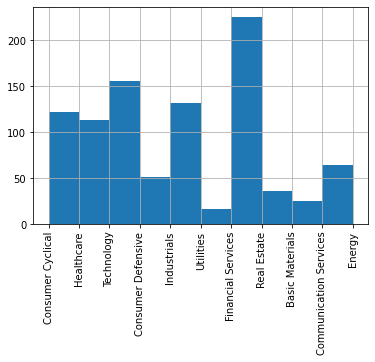

In [18]:
data_collection['sector'].hist(xrot=90)

# Test Profile => Growth
### Need ?
#### Sectors: Technology, Energy, real estate, consumer cyclical, communication services
#### High return
#### low correlation
#### max 40 stocks


In [21]:
sectors = ['Technology', 'Energy', 'Real Estate', 'Consumer Cyclical', 'Communication Services']

In [29]:
ind_data = data_collection[data_collection['sector'].isin(sectors)]
ind_data

,ticker,name,sector,Earnings_expectation,irv_status,capm_status,esg_status,current_price,annu_return_10y,market_cap,...,beta,eps_ttm,growth_estimate_5y,pe_forward,pe_trailing,irv_FairValue,ESG_risk,capm_expected_return,AHV_5y,annu_return_5y
0,AAP,Advance Auto Parts Inc.,Consumer Cyclical,Increase,Above Fair Price,UnderValued,Sustainable,214.1500,0.103398,1.308405e+10,...,1.25,9.550,0.1525,13.932986,22.424082,109.188247,12.97,0.171149,0.355467,0.049267
2,ACN,Accenture plc,Technology,Increase,Above Fair Price,OverValued,Sustainable,323.9050,0.208836,2.047083e+11,...,1.21,9.613,0.1135,31.025385,33.694477,121.148794,9.45,0.166287,0.254874,0.245322
5,ADSK,"Autodesk, Inc.",Technology,Increase,Below Fair Price,UnderValued,Sustainable,217.3800,0.190997,4.781773e+10,...,1.43,5.928,0.2883,31.967648,36.670040,302.038344,15.45,0.193030,0.384894,0.209161
10,AKAM,"Akamai Technologies, Inc.",Technology,Increase,Above Fair Price,OverValued,Sustainable,100.9400,0.106071,1.625134e+10,...,0.54,3.930,0.1200,15.340426,25.684479,39.784596,19.94,0.084842,0.310949,0.083670
13,AMAT,"Applied Materials, Inc.",Technology,Increase,Above Fair Price,OverValued,Sustainable,132.9797,0.284762,1.181542e+11,...,1.38,6.400,0.1654,15.025955,20.778078,74.946251,11.60,0.186952,0.433658,0.321131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929,WW,"WW International, Inc.",Consumer Cyclical,Increase,Above Fair Price,UnderValued,No Data,10.4000,-0.182074,7.282184e+08,...,1.59,0.700,-0.0670,6.011560,14.857142,0.791877,999.00,0.212479,0.702709,-0.028970
933,XRX,Xerox Holdings Corporation,Technology,Increase,Above Fair Price,UnderValued,No Data,20.6059,0.029031,3.678401e+09,...,1.75,1.459,-0.1600,10.302950,14.123303,0.609810,999.00,0.231929,0.405374,-0.032851
934,ZD,"Ziff Davis, Inc.",Communication Services,Increase,Above Fair Price,OverValued,No Data,102.4800,0.145864,4.941668e+09,...,1.01,4.120,0.1140,14.193907,24.873789,38.485339,999.00,0.141975,0.308007,0.055993
935,ZUMZ,Zumiez Inc.,Consumer Cyclical,Decrease,Above Fair Price,UnderValued,No Data,42.6600,0.035214,9.777245e+08,...,1.68,4.870,0.1500,9.233767,8.759754,21.330001,999.00,0.223419,0.513665,0.157523


In [38]:
top_40_ret = ind_data['annu_return_5y'].sort_values(ascending=False)[:40]

In [42]:
top_40_ret_data = ind_data.loc[top_40_ret.index]
top_40_ret_data

,ticker,name,sector,Earnings_expectation,irv_status,capm_status,esg_status,current_price,annu_return_10y,market_cap,...,beta,eps_ttm,growth_estimate_5y,pe_forward,pe_trailing,irv_FairValue,ESG_risk,capm_expected_return,AHV_5y,annu_return_5y
244,APPS,"Digital Turbine, Inc.",Technology,Increase,Below Fair Price,UnderValued,No Data,43.8000,0.278657,4.232205e+09,...,2.19,0.530,0.5000,20.372091,82.641510,239.323247,999.00,0.285415,0.719036,1.325025
890,TTD,"The Trade Desk, Inc.",Technology,Increase,Below Fair Price,OverValued,No Data,73.6800,0.376786,3.793717e+10,...,2.33,0.561,0.2800,80.967030,131.336900,96.589249,999.00,0.302433,0.683392,0.956083
199,TSLA,"Tesla, Inc.",Consumer Cyclical,Increase,Below Fair Price,OverValued,Average,806.0500,0.609586,8.094838e+11,...,2.04,3.062,0.7295,92.014840,263.242980,15861.217598,28.54,0.267181,0.611157,0.739589
350,CROX,"Crocs, Inc.",Consumer Cyclical,Decrease,Above Fair Price,UnderValued,No Data,81.1900,0.148007,4.777821e+09,...,1.79,11.456,0.1000,8.483804,7.087116,27.209850,999.00,0.236791,0.568076,0.654338
14,AMD,"Advanced Micro Devices, Inc.",Technology,Increase,Below Fair Price,OverValued,No Data,117.1100,0.319034,1.414232e+11,...,1.95,3.242,0.3532,35.062874,36.122765,253.245268,999.00,0.256240,0.564107,0.569607
893,TTGT,"TechTarget, Inc.",Communication Services,Increase,Below Fair Price,OverValued,No Data,73.2000,0.263308,2.109602e+09,...,0.89,0.694,0.3883,28.262548,105.475500,199.319788,999.00,0.127388,0.455710,0.540216
613,LSCC,Lattice Semiconductor Corporati,Technology,Increase,Above Fair Price,OverValued,No Data,59.3400,0.245040,8.126020e+09,...,0.95,0.589,0.1500,49.041320,100.747030,29.670000,999.00,0.134681,0.469995,0.526091
405,ENTG,"Entegris, Inc.",Technology,Increase,Above Fair Price,OverValued,No Data,126.8500,0.303089,1.718538e+10,...,1.14,2.760,0.2153,32.525640,45.960144,104.263280,999.00,0.157777,0.394758,0.472397
913,VICR,Vicor Corporation,Technology,Increase,Above Fair Price,OverValued,No Data,91.8000,0.266169,4.017948e+09,...,0.78,1.316,0.2000,37.777780,69.756840,67.322982,999.00,0.114016,0.531365,0.464130
728,PCTY,Paylocity Holding Corporation,Technology,Increase,Above Fair Price,OverValued,No Data,196.3400,0.233694,1.080386e+10,...,1.34,1.590,0.2000,68.891230,123.484270,143.989034,999.00,0.182089,0.428948,0.425362


<AxesSubplot:>

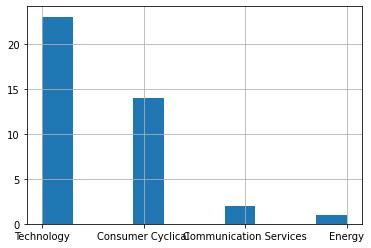

In [43]:
top_40_ret_data['sector'].hist()

# TEST mini

In [61]:
def calculate_returns(weights, log_returns):
    # Annual log Returns

    return np.sum(log_returns.mean()*weights) * 252

In [62]:
n = len(adjClose_5y[top_40_ret_data['ticker']].columns)
log_returns_test = np.log(adjClose_5y[top_40_ret_data['ticker']] / adjClose_5y[top_40_ret_data['ticker']].shift(1)).dropna() # Same as 1 + stocks_data.pct_change()
log_returns_test

,APPS,TTD,TSLA,CROX,AMD,TTGT,LSCC,ENTG,VICR,PCTY,...,SYNA,LGIH,CLAR,PENN,RICK,SPSC,QCOM,FLL,MIME,RCKY
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-06,0.000000,-0.004158,0.025301,0.005891,0.107564,-0.006803,-0.030389,-0.010257,-0.016921,-0.028416,...,0.004045,-0.126355,0.008368,-0.038230,-0.003965,-0.027496,-0.001889,0.016195,-0.012043,-0.029853
2017-02-07,0.014389,-0.008718,-0.001126,-0.022273,-0.025261,0.001137,-0.027009,0.012804,-0.010292,-0.003241,...,-0.004750,0.000000,-0.042560,0.030415,0.008477,-0.006013,0.007348,0.000000,0.015719,-0.030772
2017-02-08,0.000000,-0.007383,0.017708,0.016382,0.020112,-0.001137,-0.004332,0.004063,-0.020907,-0.010083,...,-0.005304,-0.007997,0.000000,0.000000,-0.013598,-0.209032,-0.007159,-0.004024,0.037808,0.000000
2017-02-09,0.014185,0.024400,0.026805,0.033409,-0.010378,0.006803,-0.007262,0.023542,0.007018,0.045449,...,0.000000,0.024158,0.008658,0.015570,0.022561,0.047187,-0.000189,-0.012171,0.018381,0.030772
2017-02-10,0.027780,0.000344,0.000111,0.015592,0.011852,-0.003396,-0.001459,0.036456,-0.010545,0.015824,...,-0.001774,0.011688,-0.053110,-0.019143,-0.012346,0.017572,0.020959,0.004073,-0.106035,0.012903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-17,-0.039260,-0.018713,-0.052286,-0.143953,-0.046257,-0.034062,-0.050718,-0.014058,-0.060255,-0.050709,...,-0.054665,-0.041310,-0.048945,-0.015095,-0.043347,-0.030580,-0.034181,-0.037082,-0.002134,-0.028379
2022-02-18,-0.040005,-0.017275,-0.022351,-0.035083,0.012909,-0.030836,-0.016340,-0.025107,-0.036315,-0.026768,...,-0.026641,0.011737,-0.003723,-0.042251,0.018095,-0.007235,0.005023,-0.028171,-0.004156,-0.018309
2022-02-22,-0.055883,-0.042532,-0.042246,0.024059,0.015862,-0.018096,-0.022660,-0.025990,-0.024785,0.020219,...,-0.018940,-0.029066,-0.001867,-0.024196,-0.013501,-0.020801,-0.010494,0.000000,0.001261,-0.016644


In [63]:
def function_to_minimize(weights):

    # minimize a -1 * SR (that's how the math works here, but it is the same as maximizing SR)
    return -1 * ((calculate_returns(weights, log_returns_test) - 0 )/calculate_volatility(weights, log_returns_test)) # assuming rf =0


In [64]:
required_return = 0.30
constraints = ({'type':'eq','fun': lambda weights: np.sum(weights)-1},
               {'type':'eq','fun': lambda weights: calculate_returns(weights,log_returns_test) - required_return})
bounds = tuple((0,1) for n in range(n))
equal_weights = n * [1/n] #going to be our starting point then the function will look at either direction for minimum negative SG

In [67]:
def calculate_vol(weights):
    annualized_cov = np.dot(log_returns_test.cov()*252,weights)
    vol = np.dot(weights.transpose(),annualized_cov)
    return np.sqrt(vol)

In [68]:
result = minimize(fun=calculate_vol,x0=equal_weights,bounds=bounds,constraints=constraints)
result

     fun: 0.2549121591676163
     jac: array([0.35548767, 0.36370526, 0.2889859 , 0.29052241, 0.30612553,
       0.27227355, 0.27758462, 0.26717773, 0.30448331, 0.27562267,
       0.26181399, 0.26131413, 0.38925728, 0.26745997, 0.2610479 ,
       0.26026881, 0.27778076, 0.25956254, 0.25736207, 0.27214756,
       0.25588226, 0.25581168, 0.25542855, 0.27005498, 0.37137163,
       0.28191709, 0.35504888, 0.26291219, 0.34425329, 0.30234186,
       0.26637664, 0.26689104, 0.24992815, 0.40580769, 0.29044875,
       0.24928007, 0.24938603, 0.30086101, 0.248838  , 0.24851177])
 message: 'Optimization terminated successfully'
    nfev: 369
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.00000000e+00, 4.10230166e-17, 4.45571528e-03, 1.76145130e-18,
       0.00000000e+00, 5.87845576e-02, 0.00000000e+00, 4.23865542e-17,
       1.81855995e-17, 0.00000000e+00, 6.97375281e-02, 2.57854224e-02,
       9.75842631e-18, 0.00000000e+00, 3.33374799e-02, 7.12613712e-02,
       0.0000000

In [70]:
min_var_weights = result['x']
min_var_weights

array([0.00000000e+00, 4.10230166e-17, 4.45571528e-03, 1.76145130e-18,
       0.00000000e+00, 5.87845576e-02, 0.00000000e+00, 4.23865542e-17,
       1.81855995e-17, 0.00000000e+00, 6.97375281e-02, 2.57854224e-02,
       9.75842631e-18, 0.00000000e+00, 3.33374799e-02, 7.12613712e-02,
       0.00000000e+00, 1.04044420e-02, 4.76068854e-03, 7.13620907e-18,
       1.21961066e-01, 1.07959011e-01, 9.40917409e-03, 2.29637645e-18,
       4.70527397e-17, 3.78405316e-17, 1.20984043e-17, 0.00000000e+00,
       0.00000000e+00, 6.73851330e-18, 0.00000000e+00, 1.61136735e-18,
       1.42962778e-01, 3.55105039e-17, 3.83861881e-17, 1.14575571e-01,
       9.75425605e-02, 0.00000000e+00, 7.57409631e-02, 5.13216709e-02])

In [85]:
result['x']
portfolio = {}
p = 0
for i in result['x']:
    print('Put',(i*100).round(3), "% in", log_returns_test.columns[p])

    portfolio[log_returns_test.columns[p]] = (i*100).round(3)
    p += 1

Put 0.0 % in APPS
Put 0.0 % in TTD
Put 0.446 % in TSLA
Put 0.0 % in CROX
Put 0.0 % in AMD
Put 5.878 % in TTGT
Put 0.0 % in LSCC
Put 0.0 % in ENTG
Put 0.0 % in VICR
Put 0.0 % in PCTY
Put 6.974 % in NOVT
Put 2.579 % in EPAM
Put 0.0 % in RIOT
Put 0.0 % in EGAN
Put 3.334 % in PRFT
Put 7.126 % in ASML
Put 0.0 % in MELI
Put 1.04 % in AVID
Put 0.476 % in REGI
Put 0.0 % in FOXF
Put 12.196 % in AUDC
Put 10.796 % in LULU
Put 0.941 % in HEAR
Put 0.0 % in CHDN
Put 0.0 % in GDEN
Put 0.0 % in KLAC
Put 0.0 % in ON
Put 0.0 % in FIVE
Put 0.0 % in ACLS
Put 0.0 % in AMAT
Put 0.0 % in SYNA
Put 0.0 % in LGIH
Put 14.296 % in CLAR
Put 0.0 % in PENN
Put 0.0 % in RICK
Put 11.458 % in SPSC
Put 9.754 % in QCOM
Put 0.0 % in FLL
Put 7.574 % in MIME
Put 5.132 % in RCKY


In [90]:
cleaned_portfolio = {}
for n in portfolio:
    if portfolio[n] != 0:
        cleaned_portfolio[n] = portfolio[n]
cleaned_portfolio

{'TSLA': 0.446,
 'TTGT': 5.878,
 'NOVT': 6.974,
 'EPAM': 2.579,
 'PRFT': 3.334,
 'ASML': 7.126,
 'AVID': 1.04,
 'REGI': 0.476,
 'AUDC': 12.196,
 'LULU': 10.796,
 'HEAR': 0.941,
 'CLAR': 14.296,
 'SPSC': 11.458,
 'QCOM': 9.754,
 'MIME': 7.574,
 'RCKY': 5.132}

In [113]:
list(cleaned_portfolio.keys())

['TSLA',
 'TTGT',
 'NOVT',
 'EPAM',
 'PRFT',
 'ASML',
 'AVID',
 'REGI',
 'AUDC',
 'LULU',
 'HEAR',
 'CLAR',
 'SPSC',
 'QCOM',
 'MIME',
 'RCKY']

In [117]:
cleaned_pf_data = data_collection[data_collection['ticker'].isin(list(cleaned_portfolio.keys()))]
cleaned_pf_data

,ticker,name,sector,Earnings_expectation,irv_status,capm_status,esg_status,current_price,annu_return_10y,market_cap,...,beta,eps_ttm,growth_estimate_5y,pe_forward,pe_trailing,irv_FairValue,ESG_risk,capm_expected_return,AHV_5y,annu_return_5y
73,EPAM,"EPAM Systems, Inc.",Technology,Increase,Below Fair Price,OverValued,No Data,428.835,0.408649,2.432335e+10,...,1.43,7.211,0.2850,38.391674,59.469560,582.247739,999.00,0.193030,0.376405,0.422642
176,QCOM,QUALCOMM Incorporated,Technology,Increase,Below Fair Price,UnderValued,Sustainable,165.650,0.130769,1.855280e+11,...,1.27,7.870,0.2562,14.231099,21.048285,183.404501,18.00,0.173580,0.375961,0.297623
199,TSLA,"Tesla, Inc.",Consumer Cyclical,Increase,Below Fair Price,OverValued,Average,806.050,0.609586,8.094838e+11,...,2.04,3.062,0.7295,92.014840,263.242980,15861.217598,28.54,0.267181,0.611157,0.739589
249,ASML,ASML Holding N.V. - New York Re,Technology,Increase,Below Fair Price,OverValued,No Data,634.790,0.341963,2.580256e+11,...,0.95,15.017,0.2980,32.420326,42.271423,943.608234,999.00,0.134681,0.360669,0.411064
258,AUDC,AudioCodes Ltd.,Technology,Increase,Below Fair Price,OverValued,No Data,27.675,0.234188,9.141052e+08,...,0.54,1.028,0.2500,16.875000,26.921206,29.306718,999.00,0.084842,0.446357,0.362672
259,AVID,"Avid Technology, Inc.",Communication Services,Increase,Above Fair Price,UnderValued,No Data,29.930,0.097825,1.347508e+09,...,1.22,0.717,0.1500,19.690790,41.743374,14.965000,999.00,0.167502,0.613275,0.402675
326,CLAR,Clarus Corporation,Consumer Cyclical,Increase,Below Fair Price,UnderValued,No Data,21.410,0.104810,7.919045e+08,...,0.85,0.554,0.3290,13.993464,38.646206,39.357808,999.00,0.122525,0.393534,0.306635
508,HEAR,Turtle Beach Corporation,Technology,Decrease,Above Fair Price,UnderValued,No Data,21.250,0.028783,3.409775e+08,...,1.50,1.627,0.1600,13.535031,13.060848,11.486039,999.00,0.201539,0.801657,0.359414
616,LULU,lululemon athletica inc.,Consumer Cyclical,Increase,Below Fair Price,UnderValued,Sustainable,304.580,0.164012,3.938189e+10,...,1.32,6.661,0.2790,32.927567,45.725870,396.484079,16.06,0.179658,0.392863,0.361296
645,MIME,Mimecast Limited,Technology,Increase,Above Fair Price,OverValued,No Data,79.340,0.228902,5.286860e+09,...,1.47,0.662,0.1650,50.858974,119.848940,44.577423,999.00,0.197892,0.418350,0.296223


<AxesSubplot:>

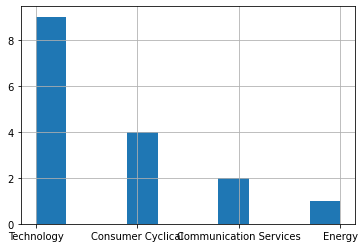

In [118]:
cleaned_pf_data['sector'].hist()

# ___________________

In [ ]:
log_returns = np.log(adjClose_5y / adjClose_5y.shift(1)) # Same as 1 + stocks_data.pct_change()
log_returns

In [ ]:
n = len(adjClose_5y.columns)

In [ ]:
def gen_weights(n):
    weights = np.random.random(n)

    return weights / np.sum(weights)

In [ ]:
def calculate_returns(weights, log_returns):
    # Annual log Returns

    return np.sum(log_returns.mean()*weights) * 252

In [ ]:
def calculate_volatility(weights, log_returns):
    annualized_cov = np.dot(log_returns.cov()*252, weights)
    vol = np.dot(weights.transpose(), annualized_cov)

    return np.sqrt(vol)

In [ ]:
calculate_volatility(gen_weights(n), log_returns)

In [ ]:
mc_portfolio_returns = []
mc_portfolio_vol = []
mc_weights = []

for sim in range(20000):

    weights = gen_weights(n)
    mc_weights.append(weights)

    mc_portfolio_returns.append(calculate_returns(weights, log_returns))

    mc_portfolio_vol.append(calculate_volatility(weights, log_returns))



In [ ]:
mc_sharpe_ratio = (np.array(mc_portfolio_returns) - 0 )/np.array(mc_portfolio_vol) # assuming rf =0

In [ ]:
plt.figure(figsize = (10,5))
plt.scatter(mc_portfolio_vol, mc_portfolio_returns, c=mc_sharpe_ratio)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Returns')

plt.show()


# ------------------------------

In [ ]:
mc_weights[np.argmax(mc_sharpe_ratio)]


['AAPL', 'ARKK', 'TSLA', 'AMZN', 'MSFT', 'GOOGL', 'JPM', 'NFLX']
array([0.02920397, 0.02217007, 0.07986235, 0.40333344, 0.281858  ,
       0.05538882, 0.04158916, 0.08659419])

array([0.16056466, 0.0022723 , 0.11224832, 0.33140994, 0.16490515,
       0.02462714, 0.02794456, 0.17602793])

# Max SH

In [ ]:
def function_to_minimize(weights):

    # minimize a -1 * SR (that's how the math works here, but it is the same as maximizing SR)
    return -1 * ((calculate_returns(weights, log_returns) - 0 )/calculate_volatility(weights, log_returns)) # assuming rf =0


In [ ]:
bounds = tuple((0,1) for n in range(n))
sum_constraint = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1}) # Read the documentation for minimize for more details
equal_weights = n * [1/n] #going to be our starting point then the function will look at either direction for minimum negative SG

In [ ]:
results = minimize(fun=function_to_minimize,
        x0=equal_weights,
        bounds=bounds,
        constraints=sum_constraint)

In [ ]:
results

In [ ]:
# weights for optimal portfolio using historical data SR
results['x']
p = 0
for i in results['x']:
    print('Put',(i*100).round(3), "% in", stocks_data.columns[p])
    p += 1

# Min Var for given return

In [ ]:
required_return = 0.4

In [ ]:
constraints = ({'type':'eq','fun': lambda weights: np.sum(weights)-1},
               {'type':'eq','fun': lambda weights: calculate_returns(weights,log_returns) - required_return})

In [ ]:
bounds = tuple((0,1) for n in range(n))
equal_weights = n * [1/n] #going to be our starting point then the function will look at either direction for minimum negative SG

In [ ]:
def calculate_vol(weights):
    annualized_cov = np.dot(log_returns.cov()*252,weights)
    vol = np.dot(weights.transpose(),annualized_cov)
    return np.sqrt(vol)

In [ ]:
result = minimize(fun=calculate_vol,x0=equal_weights,bounds=bounds,constraints=constraints)

In [ ]:
result


In [ ]:
min_var_weights = result['x']

In [ ]:
min_var_weights

In [ ]:
calculate_vol(min_var_weights)

# Max return for given vol

In [ ]:
required_vol = 0.4

In [ ]:
constraints = ({'type':'eq','fun': lambda weights: np.sum(weights)-1},
               {'type':'eq','fun': lambda weights: calculate_vol(weights) - required_vol})

In [ ]:
bounds = tuple((0,1) for n in range(n))
equal_weights = n * [1/n] #going to be our starting point then the function will look at either direction for minimum negative SG

In [ ]:
def calculate_ret(weights):
    # Annual log Returns

    return -1 * np.sum(log_returns.mean()*weights) * 252

In [ ]:
result = minimize(fun=calculate_ret,x0=equal_weights,bounds=bounds,constraints=constraints)

In [ ]:
result

In [ ]:
calculate_ret(result['x']) * -1

In [ ]:
given_ret = 0.3
given_vol = 0.4

In [ ]:
constraints = ({'type':'eq','fun': lambda weights: np.sum(weights)-1},
               {'type':'eq','fun': lambda weights: calculate_vol(weights) - given_vol},
               {'type':'eq','fun': lambda weights: calculate_returns(weights,log_returns) - given_ret})

In [ ]:
bounds = tuple((0,1) for n in range(n))
equal_weights = n * [1/n] #going to be our starting point then the function will look at either direction for minimum negative SG

In [ ]:
def function_to_minimize(weights):

    # minimize a -1 * SR (that's how the math works here, but it is the same as maximizing SR)
    return -1 * ((calculate_returns(weights, log_returns) - 0 )/calculate_volatility(weights, log_returns)) # assuming rf =0


In [ ]:
results = minimize(fun=function_to_minimize,
        x0=equal_weights,
        bounds=bounds,
        constraints=constraints)

In [ ]:
results